In [1]:
%load_ext autoreload
# not autoreloading - raises TypeError in super().__init__() calls for models
from models import *
from utils import *

from tqdm import tqdm
from pprint import pprint
import json
import _pickle as pkl
from time import time

In [2]:
glove = setup_glove()
print(glove.vectors.size())
VOCAB_SIZE = glove.vectors.size()[0]
with open('../data/data.json', 'r') as f:
    data = json.load(f)

torch.Size([400004, 50])


In [3]:
idx = 5
example_X = (data['X_train'][idx])
example_y = (data['y_train'][idx])
print("ID:", example_X[0])
print("Context:", example_X[1])
print("Question:", example_X[2])
print("Answer Span:", example_y)
print("Answer:", example_X[3])
X, y = make_data([example_X], [example_y])
pprint(y)
print(get_answer_span(y[0], example_X[1]))
num_ex = 500
X_pass, y_pass = make_data(data['X_train'][:num_ex], data['y_train'][:num_ex])

ID: 56ce602faab44d1400b88713
Context: A solar chimney (or thermal chimney, in this context) is a passive solar ventilation system composed of a vertical shaft connecting the interior and exterior of a building. As the chimney warms, the air inside is heated causing an updraft that pulls air through the building. Performance can be improved by using glazing and thermal mass materials in a way that mimics greenhouses.
Question: What kind of system is a solar chimney?
Answer Span: [59, 84]
Answer: passive solar ventilation
[(11, 13)]
passive solar ventilation


In [6]:
conf = {"vocab": glove.vectors,
    "learning_rate": 1e-3,
        "epochs": 5,
        "hidden_size": 64,
       "batch_size": 20,
       "opt": "Adam",
        "n_layers": 1}
model = ModelV2(conf)
print(model, model.lr, model.hidden_size, model.batch_size, model.opt)
model_name = "BiGRU_%s_%s_%s_%s"%(num_ex, model.epochs, model.hidden_size, model.n_layers)
print(model_name)

ModelV2(
  (encoder_c): Embedding(400004, 50)
  (encoder_q): Embedding(400004, 50)
  (gru_c): GRU(50, 64, bidirectional=True)
  (gru_q): GRU(50, 64, bidirectional=True)
  (gru_op): GRU(200, 64, bidirectional=True)
  (decoder_start): Linear(in_features=64, out_features=600, bias=True)
  (decoder_end): Linear(in_features=64, out_features=600, bias=True)
) 0.001 64 20 <class 'torch.optim.adam.Adam'>
BiGRU_500_5_64_1


In [7]:
tic = time()
res = model.fit(X_pass, y_pass)
toc = time()
print("took", toc-tic, "seconds")
torch.save(model, '../evaluation/models/%s'%model_name)

epoch: 0
0 : 12.7932
1 : 12.7652
2 : 12.7531
3 : 12.7772
4 : 12.7267
5 : 12.7425
6 : 12.7366
7 : 12.634
8 : 12.6252
9 : 12.6334
10 : 12.51
11 : 12.4733
12 : 12.4461
13 : 12.3964
14 : 12.4161
15 : 12.4398
16 : 12.3354
17 : 12.1133
18 : 12.3276
19 : 12.1168
20 : 11.8339
21 : 12.109
22 : 11.668
23 : 11.3278
24 : 11.6849

loss (epoch): 15.469271993637085, change: 00.0%
epoch: 1
0 : 10.961
1 : 10.9879
2 : 10.8895
3 : 10.9127
4 : 10.9319
5 : 11.0508
6 : 10.9903
7 : 10.9001
8 : 10.8247
9 : 10.926
10 : 10.5408
11 : 10.5561
12 : 10.6691
13 : 10.6224
14 : 10.6624
15 : 10.7653
16 : 10.6793
17 : 10.5544
18 : 10.8997
19 : 10.5615
20 : 10.235
21 : 10.7524
22 : 10.1346
23 : 9.7854
24 : 10.3407

loss (epoch): 13.356692457199097, change: 0.136566189883205 %
epoch: 2
0 : 9.7229
1 : 9.9118
2 : 9.7245
3 : 9.768
4 : 9.9268
5 : 10.0535
6 : 10.1029
7 : 10.0539
8 : 9.9205
9 : 10.166
10 : 9.6034
11 : 9.6952
12 : 9.8999
13 : 9.9141
14 : 9.948
15 : 10.1316
16 : 10.0693
17 : 9.9498
18 : 10.3963
19 : 10.0104
20 : 

In [8]:
model = torch.load('../evaluation/models/%s'%model_name)
print(model)
print(model_name)

ModelV2(
  (encoder_c): Embedding(400004, 50)
  (encoder_q): Embedding(400004, 50)
  (gru_c): GRU(50, 64, bidirectional=True)
  (gru_q): GRU(50, 64, bidirectional=True)
  (gru_op): GRU(200, 64, bidirectional=True)
  (decoder_start): Linear(in_features=64, out_features=600, bias=True)
  (decoder_end): Linear(in_features=64, out_features=600, bias=True)
)
BiGRU_500_5_64_1


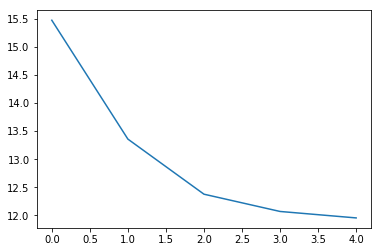

In [12]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(res))), res)
plt.show()

In [ ]:
X_test_data, y_test_data = make_data(data['X_test'][:1000], data['y_test'][:1000])

In [ ]:
dev_results = {}
seen_contexts = set()
from hashlib import sha1

model.hidden_c, model.hidden_q, model.hidden_op = model.init_hidden(1), model.init_hidden(1), model.init_hidden(1)
for i, (x, y) in enumerate(zip(X_test_data[:1000], y_test_data[:1000])):
    qid = data['X_test'][i][0]
    c = data['X_test'][i][1]
    context_h = sha1(c.encode('utf-8')).hexdigest()
    if context_h not in seen_contexts:
        print(c)
        print("-"*30)
        seen_contexts.add(context_h)
    q = data['X_test'][i][2]
    print("QUESTION: ", q)
    a = data['X_test'][i][3]
    print("ANSWER: ", a)
    res = model.predict([x], bs=1).data.tolist()[0]
    if res[0]>res[1]:
        res[0], res[1] = res[1], res[0]
    ans = get_answer_span(res, c)
    print("PRED_SPAN: ", res)
    print("PREDICTED: ", ans)
    dev_results[qid] = ans
    print("="*50)
with open('../data/run_500data_5epochs.json', 'w') as f:
    json.dump(dev_results, f)

In [ ]:
import allennlp as anlp

In [ ]:
from hashlib import sha1